## Predicting Yearly Airbnb Revenue in Boston
### Part 1: initializing

In [116]:
import pandas as pd
import os
import re
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import metrics


%matplotlib inline
from collections import Counter
import seaborn as sns
five_thirty_eight = [
    "#30a2da",
    "#fc4f30",
    "#e5ae38",
    "#6d904f",
    "#8b8b8b",
]

In [117]:
import os
cwd = os.getcwd()
df = pd.read_csv('./listings.csv')
df_reviews = pd.read_csv('./reviews.csv')
housing = pd.read_csv('./housing2.csv')

In [118]:
cols_to_keep = ['description', 'property_type', 'room_type', 'accommodates','bathrooms', 
                'bedrooms', 'beds', 'price', 
                'cleaning_fee', 'guests_included', 'extra_people', 'minimum_nights', 
                'availability_365', 'reviews_per_month','latitude', 'longitude', 'bed_type',  'neighbourhood', 'neighbourhood_cleansed',
        'host_is_superhost',  ]
df = df[cols_to_keep]


## Part 2: Data Cleaning for EDA

In [119]:
numeric_val = ['cleaning_fee', 'extra_people', 'price']
df[numeric_val] = df[numeric_val].replace('[\$,]', '', regex=True)
df[numeric_val] = df[numeric_val].apply(pd.to_numeric, errors='coerce')

In [168]:
df[numeric_val].describe()

,cleaning_fee,extra_people,price
count,3258.000000,3258.000000,3258.000000
mean,64.915592,14.497545,167.546961
std,47.053004,21.873057,121.537133
min,0.000000,0.000000,0.000000
25%,25.000000,0.000000,85.000000
50%,50.000000,5.000000,144.000000
75%,100.000000,25.000000,200.000000
max,300.000000,300.000000,1250.000000


## Part 3: EDA

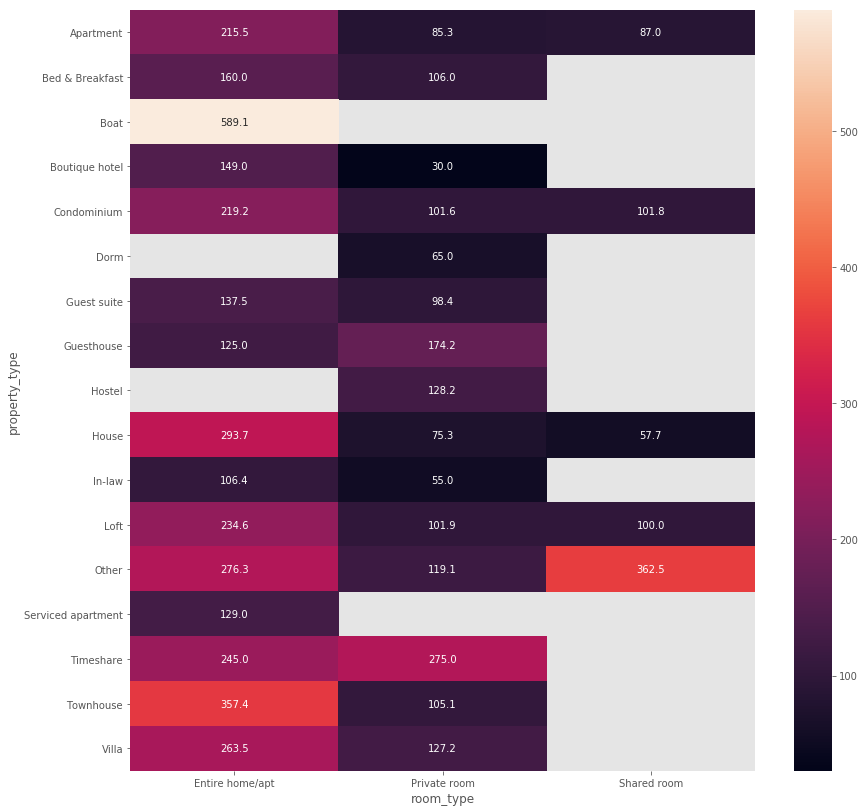

In [120]:
 plt.figure(figsize=(14,14))
sns.heatmap(df.groupby([
        'property_type', 'room_type']).price.mean().unstack(),annot=True, fmt=".1f")

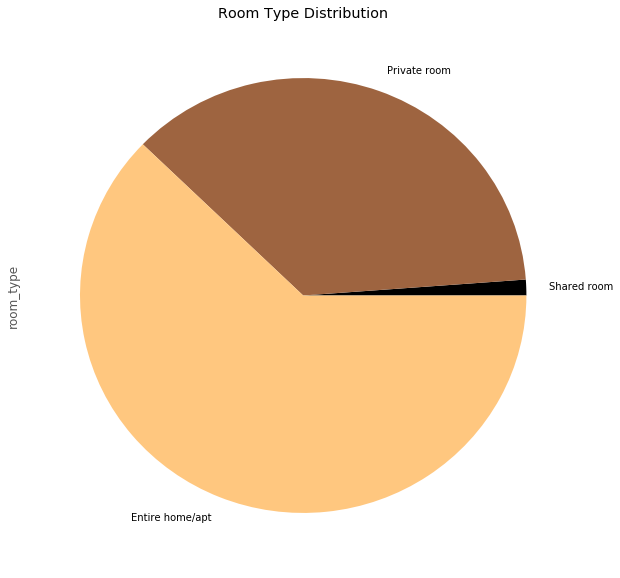

In [11]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')

room = df.room_type
r = Counter(room)

room_df = pd.DataFrame.from_dict(r, orient='index').sort_values(by=0)
room_df.columns = ['room_type']
room_df.plot.pie(y = 'room_type', colormap = 'copper', legend = False, figsize=(10,10), title = 'Room Type Distribution')

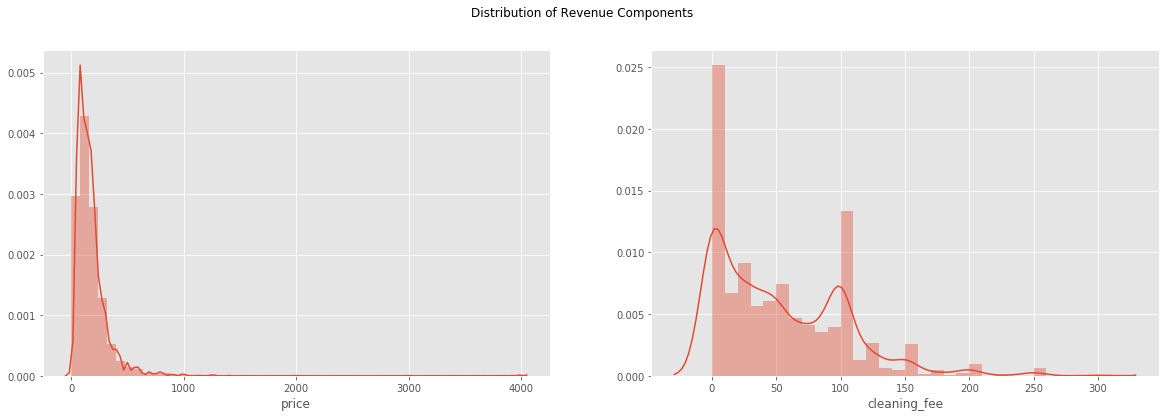

In [12]:
%matplotlib inline

fig, axs = plt.subplots(figsize=(20, 6), ncols=2)
fig.suptitle('Distribution of Revenue Components')
x=df['price'].dropna()
sns.distplot(x, ax=axs[0]);
x=df['cleaning_fee'].dropna()
sns.distplot(x, ax=axs[1]);

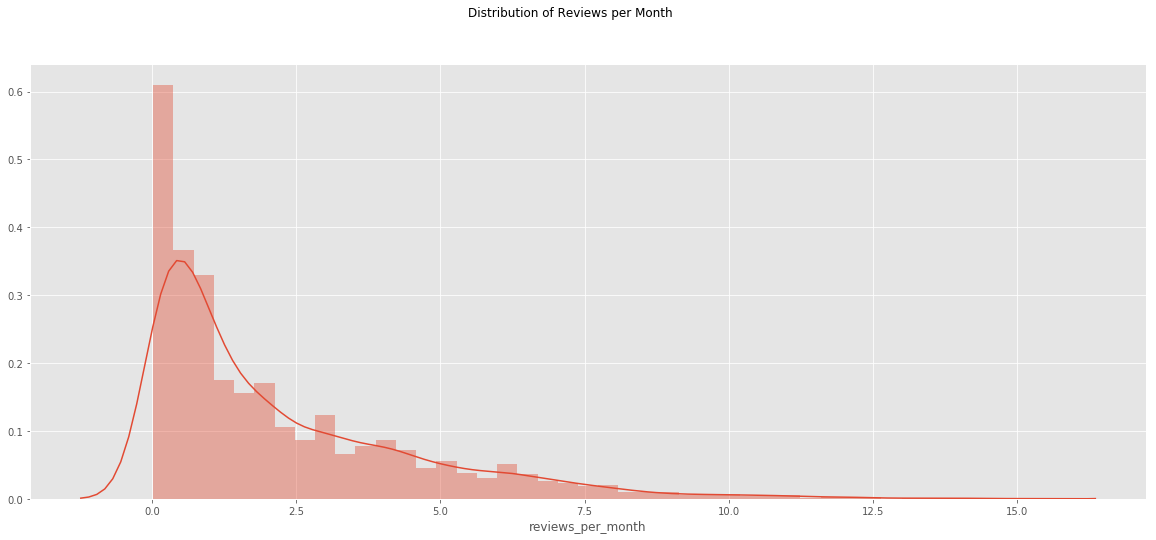

In [13]:
%matplotlib inline

fig, axs = plt.subplots(figsize=(20, 8), ncols=1)
fig.suptitle('Distribution of Reviews per Month')
x=df['reviews_per_month'].dropna()
sns.distplot(x);


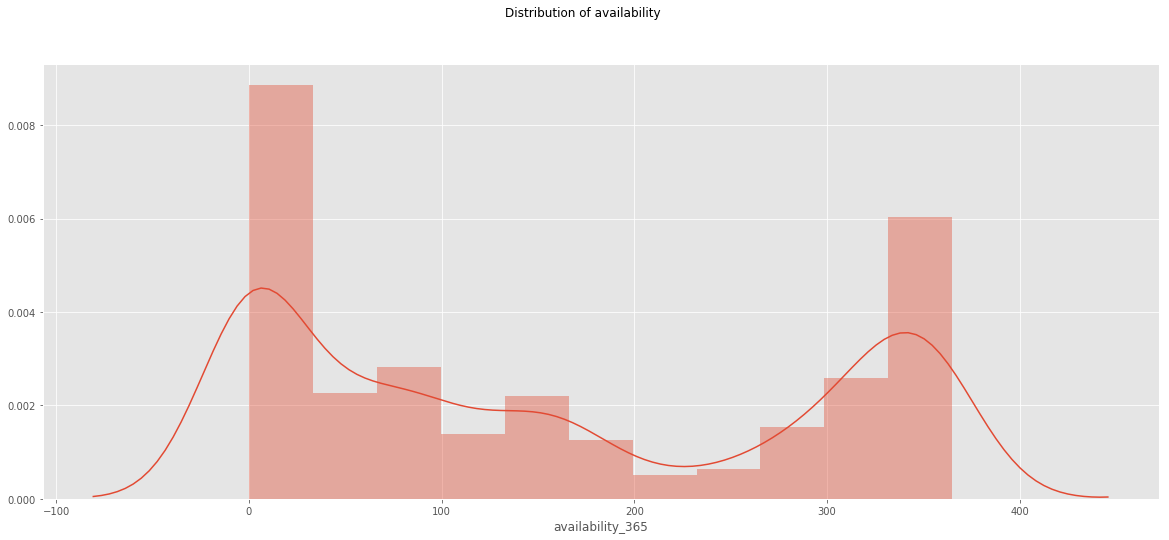

In [14]:
%matplotlib inline

fig, axs = plt.subplots(figsize=(20, 8))
fig.suptitle('Distribution of availability')
x=df['availability_365'].dropna()

sns.distplot(x)

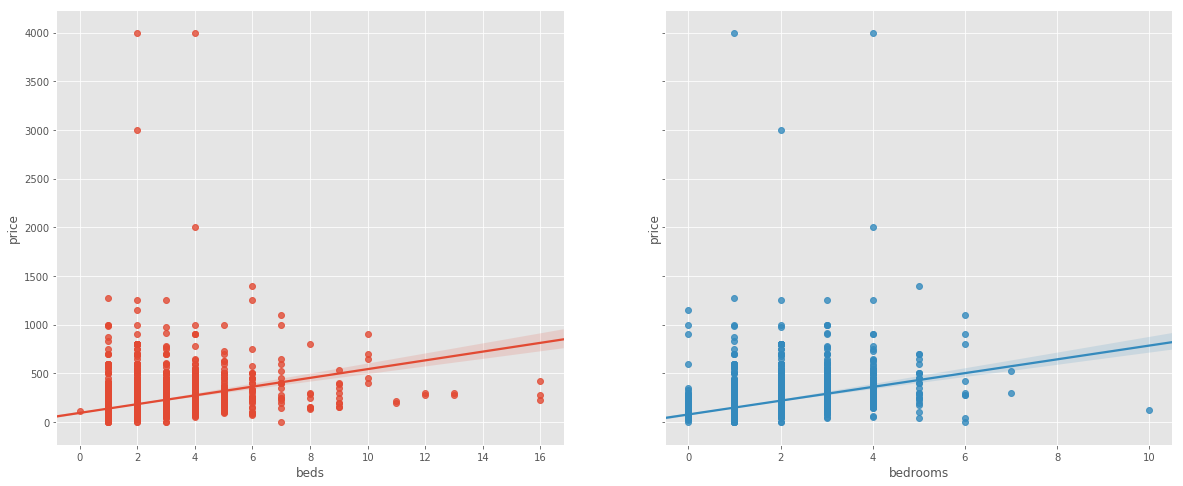

In [15]:
fig, (ax1, ax2) = plt.subplots(figsize=(20, 8), ncols=2, sharey = True)
g = sns.regplot(x=df['beds'], y=df["price"], data=df, ax=ax1)
y = sns.regplot(x=df['bedrooms'], y=df["price"], ax=ax2)

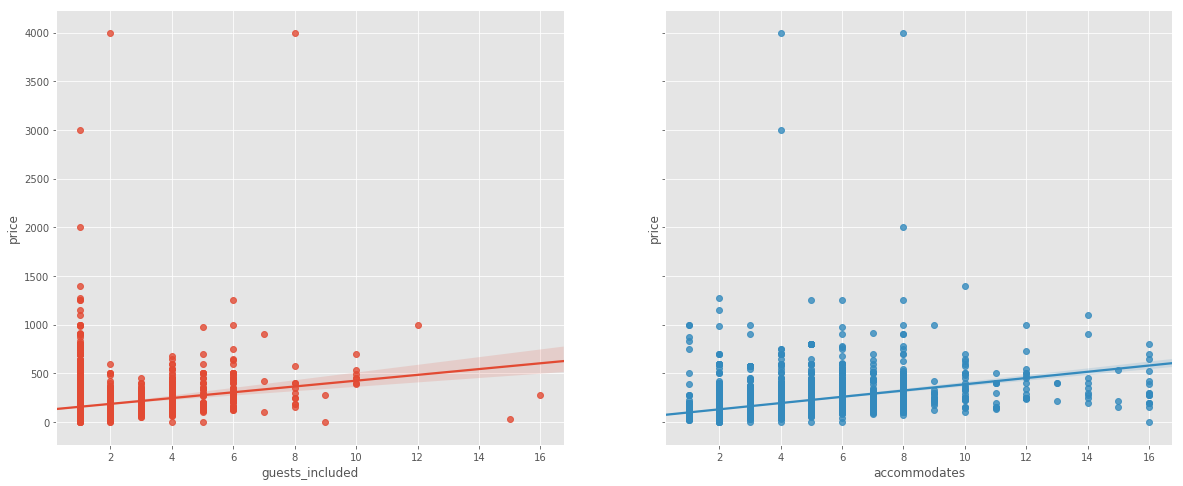

In [81]:


fig, (ax1, ax2) = plt.subplots(figsize=(20, 8), ncols=2, sharey = True)
g = sns.regplot(x=df['guests_included'], y=df["price"], data=df, ax=ax1)
y = sns.regplot(x=df['accommodates'], y=df["price"], ax=ax2)

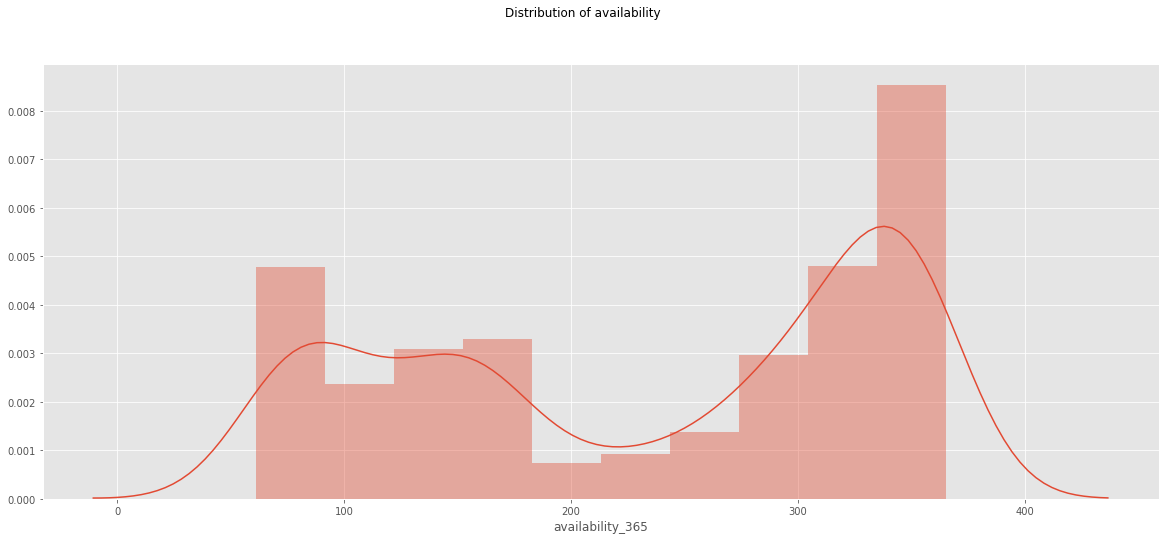

In [957]:
%matplotlib inline

fig, axs = plt.subplots(figsize=(20, 8))
fig.suptitle('Distribution of availability')
x=df['availability_365'].dropna()
sns.distplot(x)

# Pt 4: Data Cleaning / Feature Engineering

In [16]:
df = df[df.bathrooms >0]
df = df[df.bedrooms > 0]
df = df[df.beds > 0]
df = df[df.price  > 0]
df = df[df.reviews_per_month > 0]
df = df[df.accommodates  > 0]
df = df.loc[df['availability_365'] > 60]
df = df.loc[df['accommodates'] < 10]
df = df.loc[df['price']<1000]
df = df.loc[df['neighbourhood']!='Winthrop']
df = df.loc[df['reviews_per_month']<10]
df.cleaning_fee.describe()
df.cleaning_fee.isnull().sum()
df.cleaning_fee.replace(np.nan, 0, inplace=True)

In [17]:
features_change = ['Townhouse', 'Hostel', 'Timeshare', 'Bed & Breakfast', 'Loft', 'Boutique hotel', 'Boat', 'In-law', 'Guesthouse', 'Guest suite', 'Villa','Serviced apartment']
df['property_type'].loc[df['property_type'].isin(features_change)] = 'Other'
df['property_type'].value_counts()

Apartment      1452
House           495
Condominium     209
Other           143
Name: property_type, dtype: int64

In [18]:
(df.price.mean()+df.cleaning_fee.mean())*3*(df.reviews_per_month.mean()/.5)*12

36338.22831516471

In [122]:
df['new_price'] = df['price']+df['cleaning_fee']

In [87]:
df.new_price.mean()

223.86472379295347

In [123]:
length = 3
review_rate = .5
df['Revenue'] = df['new_price']*length*(df['reviews_per_month']/review_rate)*12

count      3258.000000
mean      34199.651271
std       42235.872306
min           0.000000
25%        7488.000000
50%       19544.400000
75%       44919.720000
max      733255.200000
Name: Revenue, dtype: float64

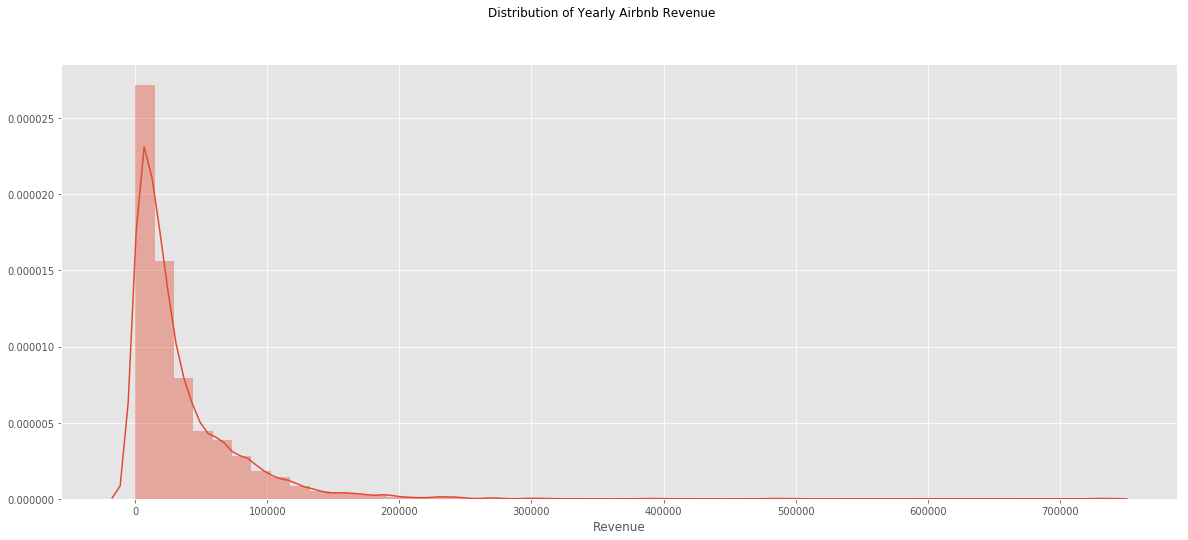

In [127]:
fig, axs = plt.subplots(figsize=(20, 8))
fig.suptitle('Distribution of Yearly Airbnb Revenue')
x=df['Revenue'].dropna()
sns.distplot(x)

x.describe()

In [29]:
df.neighbourhood_cleansed.value_counts()
features_change = ['South Boston Waterfront']
df['neighbourhood'].loc[df['neighbourhood'].isin(features_change)] = 'South End'
features_change1 = ['Theater District', 'Downtown']
df['neighbourhood'].loc[df['neighbourhood'].isin(features_change1)] = 'Downtown Crossing'
features_change2 = ['Chelsea', 'Revere']
df['neighbourhood'].loc[df['neighbourhood'].isin(features_change2)] = 'East Boston'
features_change3 = ['Hyde Park', 'West Roxbury', 'Mattapan']
df['neighbourhood'].loc[df['neighbourhood'].isin(features_change3)] = 'Mattapan'
features_change4 = ['Government Center', 'Leather District']
df['neighbourhood'].loc[df['neighbourhood'].isin(features_change4)] = 'Financial District'
features_change5 = ['Brookline', 'Somerville','Chestnut Hill', 'Cambridge', 'Harvard Square' ,'Newton', 'Coolidge Corner']
df['neighbourhood'].loc[df['neighbourhood'].isin(features_change5)] = 'Allston-Brighton'


/Users/ethanschein/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [30]:
df1 = df.merge(housing, on = 'neighbourhood', how= 'inner')
df1.isnull().sum()

description               0
property_type             0
room_type                 0
accommodates              0
bathrooms                 0
bedrooms                  0
beds                      0
price                     0
cleaning_fee              0
guests_included           0
extra_people              0
minimum_nights            0
availability_365          0
reviews_per_month         0
latitude                  0
longitude                 0
bed_type                  0
neighbourhood             0
neighbourhood_cleansed    0
host_is_superhost         0
new_price                 0
Revenue                   0
cost                      0
dtype: int64

In [129]:
df.Revenue.describe()

count      3258.000000
mean      34199.651271
std       42235.872306
min           0.000000
25%        7488.000000
50%       19544.400000
75%       44919.720000
max      733255.200000
Name: Revenue, dtype: float64

In [130]:
df_property_type = pd.get_dummies(df1['property_type'])
df_bed_type = pd.get_dummies(df1['bed_type'])
df_room_type = pd.get_dummies(df1['room_type'])
df_host = pd.get_dummies(df1['host_is_superhost'])
df_neighborhood = pd.get_dummies(df1['neighbourhood'])

In [131]:
df_new = pd.concat([df_property_type,df_bed_type, df_room_type, df_host, df1, df_neighborhood], axis=1)

In [31]:
df.neighbourhood.value_counts()

Allston-Brighton      279
Dorchester            262
Back Bay              193
Jamaica Plain         190
South Boston          160
South End             145
Roxbury               138
Fenway/Kenmore        136
East Boston           116
Beacon Hill            97
Mattapan               93
Downtown Crossing      90
North End              87
Charlestown            79
Chinatown              69
Roslindale             67
Mission Hill           37
West End               34
Financial District     27
Name: neighbourhood, dtype: int64

In [143]:
X= ['Apartment', 'Condominium', 'House', 'accommodates', 'bathrooms', 'bedrooms',
       'beds', 'guests_included',
       'minimum_nights', 'availability_365',
        'Private room',
       'Shared room', 't','Allston-Brighton', 'Back Bay', 'Beacon Hill',
       'Charlestown', 'Chinatown', 'Downtown Crossing',
       'East Boston', 'Fenway/Kenmore', 'Financial District', 'Jamaica Plain',
       'Mattapan', 'Mission Hill', 'North End', 'Roslindale', 'Roxbury',
       'South Boston', 'South End', 'West End','extra_people', 'cost']

In [85]:
y.isnull().sum()

0

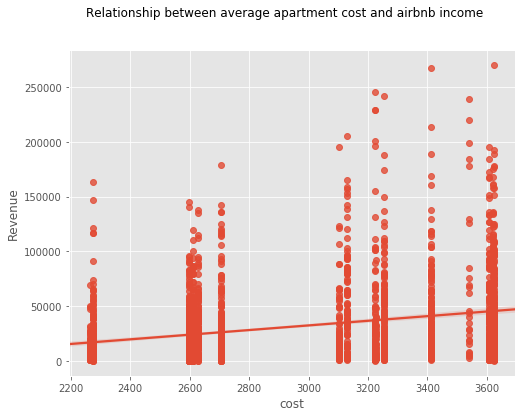

In [144]:
fig, axs = plt.subplots(figsize=(8, 6), ncols=1)
fig.suptitle('Relationship between average apartment cost and airbnb income')
g = sns.regplot(x=df_new['cost'], y=df_new["Revenue"], data=df_new)



In [145]:
# Creating a response and target variable
target = 'Revenue'
X = df_new[X]
y = df_new[target]


In [146]:
#Initializing a 70/30 test train split
test_size = 0.3

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)

In [147]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [148]:
# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [165]:
# Make predictions using the testing set
regr_y_pred = regr.predict(X_test)


# MSE
print("Mean squared error: %.2f" % mean_squared_error(y_test, regr_y_pred))
# R2 score
print('r2 score: %.2f' % r2_score(y_test, regr_y_pred))

Mean squared error: 837465590.21
r2 score: 0.31


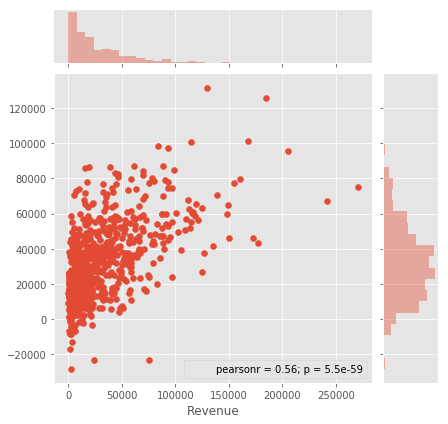

In [150]:
sns.jointplot(y_test, regr_y_pred);

In [151]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
kf = KFold(n_splits = 10, shuffle = True)
mse_values = []
scores = []
n = 0
print("CROSS VALIDATION each fold")
for train_index, test_index in kf.split(X, y):
    lr = LinearRegression().fit(X.iloc[train_index], y.iloc[train_index])
    
    mse_values.append(metrics.mean_squared_error(y.iloc[test_index], lr.predict(X.iloc[test_index])))
    scores.append(lr.score(X, y))
 
    print('Model {}'.format(n))
    print('MSE: {}'.format(mse_values[n-1]))
    print('R2: {}\n'.format(scores[n-1]))

print("SUMMARY OF CROSS VALIDATION")
print('Mean of MSE for all folds: {}'.format(np.mean(mse_values)))
print('Mean of R2 for all folds: {}'.format(np.mean(scores)))

CROSS VALIDATION each fold
Model 0
MSE: 938647570.3761894
R2: 0.35272445563647403

Model 0
MSE: 804234464.7209759
R2: 0.35258460288581706

Model 0
MSE: 858211864.0173585
R2: 0.35230924269214314

Model 0
MSE: 789479683.2478107
R2: 0.3524754661004973

Model 0
MSE: 772757597.7112331
R2: 0.35236508198108035

Model 0
MSE: 1078498224.7206442
R2: 0.35295996552629133

Model 0
MSE: 864149897.7619597
R2: 0.35219247324034464

Model 0
MSE: 1155430392.9472368
R2: 0.35272436368462035

Model 0
MSE: 1022632270.9272102
R2: 0.35238949342754866

Model 0
MSE: 935501222.3266151
R2: 0.35284451262063854

SUMMARY OF CROSS VALIDATION
Mean of MSE for all folds: 921954318.8757232
Mean of R2 for all folds: 0.35255696577954554


In [152]:
import pandas as pd
import numpy as np
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy import stats



X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                Revenue   R-squared:                       0.354
Model:                            OLS   Adj. R-squared:                  0.345
Method:                 Least Squares   F-statistic:                     38.75
Date:                Thu, 31 May 2018   Prob (F-statistic):          1.68e-188
Time:                        15:34:27   Log-Likelihood:                -26953.
No. Observations:                2299   AIC:                         5.397e+04
Df Residuals:                    2266   BIC:                         5.416e+04
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const              -2.717e+04   5544

In [169]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor

Mean squared error: 831464552.37
R2: 0.32


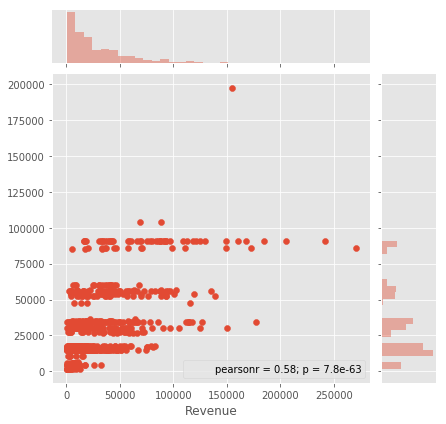

In [170]:
# Fit regression model
decision_regr = DecisionTreeRegressor(max_depth=5)
decision_regr.fit(X_train, y_train)
dt_y_pred = decision_regr.predict(X_test)
sns.jointplot(y_test, dt_y_pred); 

# MSE
print("Mean squared error: %.2f" % mean_squared_error(y_test, dt_y_pred))
# R2 Score
print('R2: %.2f' % r2_score(y_test, dt_y_pred))

In [171]:
#Gini Importance
pd.DataFrame({'feature':X.columns, 'importance':decision_regr.feature_importances_})

,feature,importance
0,Apartment,0.000000
1,Condominium,0.000731
2,House,0.000000
3,accommodates,0.307003
4,bathrooms,0.005047
5,bedrooms,0.005518
6,beds,0.000000
7,guests_included,0.009269
8,minimum_nights,0.155262
9,availability_365,0.059367


In [172]:
from sklearn.tree import export_graphviz
export_graphviz(decision_regr, out_file='./tree5.dot', feature_names=X.columns)

In [162]:
rf_regr = RandomForestRegressor(criterion='mse', max_depth=10, 
                           max_features='auto', min_samples_split=4, n_estimators=150)

rf_regr.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=4,
           min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [163]:
pd.DataFrame({'feature':X.columns, 'importance':ran_regr.feature_importances_})

,feature,importance
0,Apartment,0.007988
1,Condominium,0.010126
2,House,0.004535
3,accommodates,0.223990
4,bathrooms,0.034128
5,bedrooms,0.018947
6,beds,0.022067
7,guests_included,0.038079
8,minimum_nights,0.097386
9,availability_365,0.135750


Mean squared error: 648406866.94
R2: 0.47


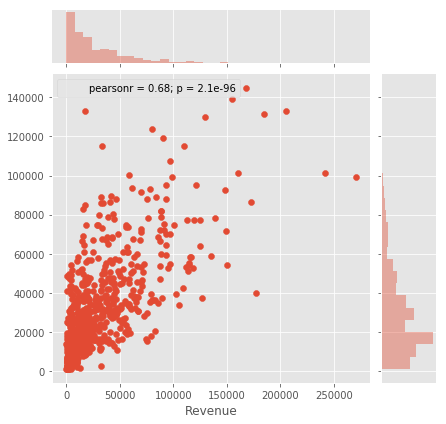

In [164]:
# Make prediction
rf_y_pred = rf_regr.predict(X_test)

# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, rf_y_pred))
# Explained variance score: 1 is perfect prediction
print('R2: %.2f' % r2_score(y_test, rf_y_pred))
sns.jointplot(y_test, rf_y_pred); 